<a href="https://colab.research.google.com/github/dvignoles/nyc-transpo/blob/master/nyc_transpo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import requests, zipfile, io, os, re, csv
import matplotlib.pyplot as plt

from preprocessing import *

In [19]:
# Set up directories and util functions to store the downloaded csv files

if os.path.isdir(BIKE_CSV_PATH) is False:
  os.mkdir(BIKE_CSV_PATH)

# Taxi Dataframes
Since these downloads take a long time, do NOT reset all run times when it asks you to! It will wipe all downloaded files, and you'll have to download them again!

#### Download, Load, and Clean

In [2]:
# Download and save the files first so they don't have to be redownloaded every time
download_taxi()

# Load the actual data
df_taxi_2013 = get_parsed_taxi_df("2013")
df_taxi_2014 = get_parsed_taxi_df("2014")
df_taxi_2015 = get_parsed_taxi_df("2015")
df_taxi_2016 = get_parsed_taxi_df("2016")
df_taxi_2017 = get_parsed_taxi_df("2017")
df_taxi_2018 = get_parsed_taxi_df("2018")

df_taxi_all  = [df_taxi_2013,df_taxi_2014,df_taxi_2015,df_taxi_2016,df_taxi_2017,df_taxi_2018]

In [3]:
#Clean column names
for df in df_taxi_all:
    df.columns = clean_col_names(df.columns)

#### Taxi Feature Engineering

In [21]:
# add trip duration column
for df in df_taxi_all:
    if not('tripduration' in df.columns):
        df['tripduration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds()

# Citi Bike Dataframes
Since Citi Bike does not directly provide csv files, we must handle the zip files, extract, and load them accordingly.

In [46]:
reg_pattern = re.compile("^\d+.*\.csv$")

for n in YEARS:
  # See if the file exists
  file_path = get_csv_name("bike", n)
  if os.path.isfile(file_path) is True:
    continue

  # If not, request and save it
  req_url = ""
  if n != "2017" and n != "2018":
    req_url = "https://s3.amazonaws.com/tripdata/" + n + "06-citibike-tripdata.zip"
  else:
    req_url = "https://s3.amazonaws.com/tripdata/" + n + "06-citibike-tripdata.csv.zip"
    
  # Handle the ZIP
  z = zipfile.ZipFile(io.BytesIO(requests.get(req_url).content))
  orig_file_name = list(filter(reg_pattern.match, z.namelist()))[0]
  z.extract(orig_file_name)
  os.rename(orig_file_name, get_csv_name("bike", n)) # Renaming the file will automatically remove the original, extracted file

In [47]:
# The dtypes can't be passed in atm because some columns that should be integers have non-number strings in them
# Some columns that should be integers are floats instead because pandas can't put NaN values in integer columns
"""
dtypes = {
    "tripduration": np.int32,
    "starttime": "str",
    "stoptime": "str",
    "start station id": np.float32,
    "start station name": "str",
    "start station latitude": np.float32,
    "start station longitude": np.float32,
    "end station id": np.float32,
    "end station name": "str",
    "end station latitude": np.float32,
    "end station longitude": np.float32,
    "bikeid": np.int32,
    "usertype": "str",
    "birth year": np.float32,
    "gender": np.int32
}
"""


df_bike_2013_orig = pd.read_csv(get_csv_name("bike", "2013"))
df_bike_2014_orig = pd.read_csv(get_csv_name("bike", "2014"))
df_bike_2015_orig = pd.read_csv(get_csv_name("bike", "2015"))
df_bike_2016_orig = pd.read_csv(get_csv_name("bike", "2016"))
df_bike_2017_orig = pd.read_csv(get_csv_name("bike", "2017"))
df_bike_2018_orig = pd.read_csv(get_csv_name("bike", "2018"))

In [48]:
# Convert to datetime. This was really annoying with the different formats - if the format is unspecified, the functions never stop running.
# Also must assert that the last row of data has a start time greater than the second week, to make sure we have the full first 2 weeks of data

# 2013
df_bike_2013_orig['starttime'] = pd.to_datetime(df_bike_2013_orig['starttime'])
df_bike_2013_orig['stoptime'] = pd.to_datetime(df_bike_2013_orig['stoptime'])
assert df_bike_2013_orig.iloc[-1].starttime > datetime.strptime('2013-06-07', '%Y-%m-%d'), "Missing full 1 week of data for 2013"

# 2014
df_bike_2014_orig['starttime'] = pd.to_datetime(df_bike_2014_orig['starttime'])
df_bike_2014_orig['stoptime'] = pd.to_datetime(df_bike_2014_orig['stoptime'])
assert df_bike_2014_orig.iloc[-1].starttime > datetime.strptime('2014-06-07', '%Y-%m-%d'), "Missing full 1 week of data for 2014"

# 2015
df_bike_2015_orig['starttime'] = pd.to_datetime(df_bike_2015_orig["starttime"], format="%m/%d/%Y %H:%M")
df_bike_2015_orig['stoptime'] = pd.to_datetime(df_bike_2015_orig['stoptime'], format="%m/%d/%Y %H:%M")
assert df_bike_2015_orig.iloc[-1].starttime > datetime.strptime('2015-06-07', '%Y-%m-%d'), "Missing full 1 week of data for 2015"

# 2016
df_bike_2016_orig['starttime'] = pd.to_datetime(df_bike_2016_orig['starttime'], format="%m/%d/%Y %H:%M:%S")
df_bike_2016_orig['stoptime'] = pd.to_datetime(df_bike_2016_orig['stoptime'], format="%m/%d/%Y %H:%M:%S")
assert df_bike_2016_orig.iloc[-1].starttime > datetime.strptime('2016-06-07', '%Y-%m-%d'), "Missing full 1 week of data for 2016"

# 2017
df_bike_2017_orig['starttime'] = pd.to_datetime(df_bike_2017_orig['starttime'], format="%Y-%m-%d %H:%M:%S")
df_bike_2017_orig['stoptime'] = pd.to_datetime(df_bike_2017_orig['stoptime'], format="%Y-%m-%d %H:%M:%S")
assert df_bike_2017_orig.iloc[-1].starttime > datetime.strptime('2017-06-07', '%Y-%m-%d'), "Missing full 1 week of data for 2017"

# 2018
df_bike_2018_orig['starttime'] = pd.to_datetime(df_bike_2018_orig['starttime'], format="%Y-%m-%d %H:%M:%S")
df_bike_2018_orig['stoptime'] = pd.to_datetime(df_bike_2018_orig['stoptime'], format="%Y-%m-%d %H:%M:%S")
assert df_bike_2018_orig.iloc[-1].starttime > datetime.strptime('2018-06-07', '%Y-%m-%d'), "Missing full 1 week of data for 2018"

In [49]:
# Our main Citi Bike dataframes we'll be using, with a full week of data for each year

df_bike_2013 = df_bike_2013_orig[(df_bike_2013_orig['starttime'] > '2013-06-01') & (df_bike_2013_orig['starttime'] < '2013-06-08')]
df_bike_2014 = df_bike_2014_orig[(df_bike_2014_orig['starttime'] > '2014-06-01') & (df_bike_2014_orig['starttime'] < '2014-06-08')]
df_bike_2015 = df_bike_2015_orig[(df_bike_2015_orig['starttime'] > '2015-06-01') & (df_bike_2015_orig['starttime'] < '2015-06-08')]
df_bike_2016 = df_bike_2016_orig[(df_bike_2016_orig['starttime'] > '2016-06-01') & (df_bike_2016_orig['starttime'] < '2016-06-08')]
df_bike_2017 = df_bike_2017_orig[(df_bike_2017_orig['starttime'] > '2017-06-01') & (df_bike_2017_orig['starttime'] < '2017-06-08')]
df_bike_2018 = df_bike_2018_orig[(df_bike_2018_orig['starttime'] > '2018-06-01') & (df_bike_2018_orig['starttime'] < '2018-06-08')]


In [ ]:
#Clean column names
df_bike_all = [df_bike_2013,df_bike_2014,df_bike_2015,df_bike_2016,df_bike_2017,df_bike_2018]
for df in df_bike_all:
    df.columns = clean_col_names(df.columns)

In [64]:
# add trip distance (distance between start and end station, in miles) to bike dataframes
# throws a bunch of errors, but idk still works so......

def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a)) * .62137


df_bike_2013['trip_distance'] = haversine(
            df_bike_2013['start_station_latitude'], 
            df_bike_2013['start_station_longitude'],
            df_bike_2013['end_station_latitude'], 
            df_bike_2013['end_station_longitude'])

df_bike_2014['trip_distance'] = haversine(
            df_bike_2014['start_station_latitude'], 
            df_bike_2014['start_station_longitude'],
            df_bike_2014['end_station_latitude'], 
            df_bike_2014['end_station_longitude'])

df_bike_2015['trip_distance'] = haversine(
            df_bike_2015['start_station_latitude'], 
            df_bike_2015['start_station_longitude'],
            df_bike_2015['end_station_latitude'], 
            df_bike_2015['end_station_longitude'])

df_bike_2016['trip_distance'] = haversine(
            df_bike_2016['start_station_latitude'], 
            df_bike_2016['start_station_longitude'],
            df_bike_2016['end_station_latitude'], 
            df_bike_2016['end_station_longitude'])

df_bike_2017['trip_distance'] = haversine(
            df_bike_2017['start_station_latitude'], 
            df_bike_2017['start_station_longitude'],
            df_bike_2017['end_station_latitude'], 
            df_bike_2017['end_station_longitude'])

df_bike_2018['trip_distance'] = haversine(
            df_bike_2018['start_station_latitude'], 
            df_bike_2018['start_station_longitude'],
            df_bike_2018['end_station_latitude'], 
            df_bike_2018['end_station_longitude'])


/home/dan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

In [63]:
df_bike_2018.head(20)

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,trip_distance,day
0,569,2018-06-01 01:57:20.514,2018-06-01 02:06:50.088,72,W 52 St & 11 Ave,40.767272,-73.993929,173,Broadway & W 49 St,40.760683,-73.984527,21481,Subscriber,1999,1,0.670309,01 (Fri)
1,480,2018-06-01 02:02:42.398,2018-06-01 02:10:43.354,72,W 52 St & 11 Ave,40.767272,-73.993929,477,W 41 St & 8 Ave,40.756405,-73.990026,19123,Subscriber,1988,1,0.778097,01 (Fri)
2,692,2018-06-01 02:04:23.624,2018-06-01 02:15:55.747,72,W 52 St & 11 Ave,40.767272,-73.993929,457,Broadway & W 58 St,40.766953,-73.981693,26983,Subscriber,1986,1,0.640655,01 (Fri)
3,664,2018-06-01 03:00:55.461,2018-06-01 03:11:59.906,72,W 52 St & 11 Ave,40.767272,-73.993929,379,W 31 St & 7 Ave,40.749156,-73.991600,26742,Subscriber,1973,1,1.257624,01 (Fri)
4,818,2018-06-01 06:04:54.427,2018-06-01 06:18:32.617,72,W 52 St & 11 Ave,40.767272,-73.993929,459,W 20 St & 11 Ave,40.746745,-74.007756,26386,Subscriber,1984,1,1.592243,01 (Fri)
5,753,2018-06-01 06:11:52.599,2018-06-01 06:24:26.198,72,W 52 St & 11 Ave,40.767272,-73.993929,446,W 24 St & 7 Ave,40.744876,-73.995299,27073,Subscriber,1981,1,1.549059,01 (Fri)
6,687,2018-06-01 07:15:15.565,2018-06-01 07:26:42.867,72,W 52 St & 11 Ave,40.767272,-73.993929,212,W 16 St & The High Line,40.743349,-74.006818,14612,Subscriber,1968,1,1.785255,01 (Fri)
7,619,2018-06-01 07:40:02.578,2018-06-01 07:50:22.028,72,W 52 St & 11 Ave,40.767272,-73.993929,458,11 Ave & W 27 St,40.751396,-74.005226,16415,Subscriber,1990,2,1.246125,01 (Fri)
8,819,2018-06-01 07:43:01.958,2018-06-01 07:56:41.328,72,W 52 St & 11 Ave,40.767272,-73.993929,212,W 16 St & The High Line,40.743349,-74.006818,31551,Subscriber,1981,1,1.785255,01 (Fri)
9,335,2018-06-01 07:49:47.934,2018-06-01 07:55:23.309,72,W 52 St & 11 Ave,40.767272,-73.993929,514,12 Ave & W 40 St,40.760875,-74.002777,26058,Subscriber,1988,2,0.640117,01 (Fri)


### Zones / Neighborhoods

Define NYC taxi zone as a feature for all df

In [66]:
import shapefile #pip install pyshp
with shapefile.Reader("./taxi_zones/geo_export_a619f821-072d-486f-8172-0c1be3f7e97d") as shp:
    shapes = shp.shapes()
    
    fields = shp.fields
    
    records = shp.records()

In [67]:
class Zone:
    def __init__(self,location_id,name,borough,area,bbox):
            self.location_id = location_id
            self.name = name
            self.borough = borough
            self.area = area
            self.bbox = bbox
    
    def __repr__(self):
        return str((self.location_id,self.name,self.borough,self.area,self.bbox))
    
    def __str__(self):
        return(self.name + ' : ' + str(self.bbox))
        
ZONES = [] #List of all Zone objects 
ZONES_DIC = {} #Dictionary of all zones with location_id as key

#Populate ZONES/ZONES_DIC
for i in range(0,len(shapes)):
    z = Zone(records[i].location_i,records[i].zone,records[i].borough,records[i].shape_area,shapes[i].bbox)
    ZONES.append(z)
    ZONES_DIC[str(z.location_id)] = z

In [68]:
def zone_lookup(lon,lat):
    '''Return Zone object if lon/lat return valid taxi zone'''
    for z in ZONES: #probably should not do this in a for loop
        
        w_lon = z.bbox[0]
        s_lat = z.bbox[1]
        e_lon = z.bbox[2]
        n_lat = z.bbox[3]
        
        if lat >= s_lat and lat <= n_lat:
            if lon >= w_lon and lon <= e_lon:
                return(z)
    return None

def zone_lookup_id(lon,lat):
    '''Get the Taxi zone ID number from lon/lat'''
    z = zone_lookup(lon,lat)
    
    if z:
        return z.location_id
    else:
        return np.nan

def zone_from_to(from_lon,from_lat,to_lon,to_lat):
    '''Return string showing taxi to from ie: Tribecca to Central park'''
    z_from = zone_lookup(from_lon,from_lat)
    z_to = zone_lookup(to_lon,to_lat)
    try:
        return z_from.name + ' to ' + z_to.name
    except:
        return np.nan


In [69]:
def add_zones(df): #ridiculously slow, sorry
    df['zone_from'] = np.vectorize(zone_lookup_id)(df.pickup_longitude,df.pickup_latitude)
    df['zone_to'] = np.vectorize(zone_lookup_id)(df.dropoff_longitude,df.dropoff_latitude)
    df['zone_from_to'] = np.vectorize(zone_from_to)(df.pickup_longitude,df.pickup_latitude,df.dropoff_longitude,df.dropoff_latitude)

#Popualte Taxi Zone Columns
for df in [df_taxi_2013,df_taxi_2014,df_taxi_2015,df_taxi_2016]: #taxi 2017/2018 use a different system in place of lon/lat
    add_zones(df)
    df.dropna(subset=['zone_from','zone_to','zone_from_to'],inplace=True)


In [78]:
def add_zones(df):
    df['zone_from'] = np.vectorize(zone_lookup_id)(df.start_station_longitude,df.start_station_latitude)
    df['zone_to'] = np.vectorize(zone_lookup_id)(df.end_station_longitude,df.end_station_latitude)
    df['zone_from_to'] = np.vectorize(zone_from_to)(df.start_station_longitude,df.start_station_latitude,df.end_station_longitude,df.end_station_latitude)

#Populate Taxi Zone Columns for citibike
for df in df_bike_all:
    add_zones(df)
    df.dropna(subset=['zone_from','zone_to','zone_from_to'],inplace=True)


/home/dan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/dan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

# Analysis

## Exploratory Data Analysis

### Trip Distance

In [82]:
# df_taxi_2015 contains some weirdly high trip distance outliers.

df_taxi_2015[df_taxi_2015.trip_distance > 500].count()

VendorID                 21
pickup_datetime          21
dropoff_datetime         21
passenger_count          21
trip_distance            21
pickup_longitude         21
pickup_latitude          21
RateCodeID               21
store_and_fwd_flag       21
dropoff_longitude        21
dropoff_latitude         21
payment_type             21
fare_amount              21
extra                    21
mta_tax                  21
tip_amount               21
tolls_amount             21
improvement_surcharge    21
total_amount             21
tripduration             21
day                      21
zone_from                21
zone_to                  21
zone_from_to             21
dtype: int64

bike mean:  1.1761182789578362
taxi mean:  3.0201556351736336


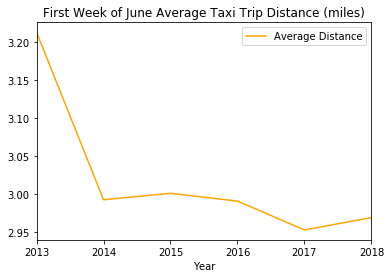

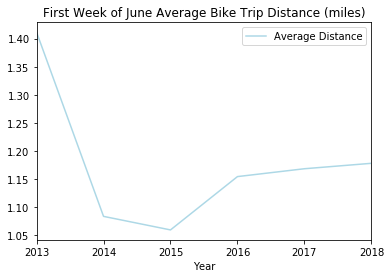

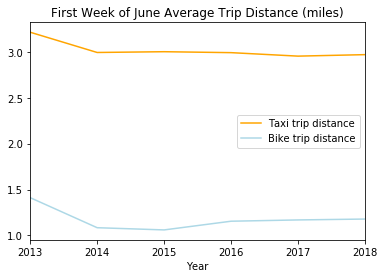

In [101]:
avg_trip_distance_bike = pd.DataFrame(
    {'Year': YEARS,
     'Average Distance': [
         df_bike_2013.trip_distance.mean(),
         df_bike_2014.trip_distance.mean(),
         df_bike_2015.trip_distance.mean(),
         df_bike_2016.trip_distance.mean(),
         df_bike_2017.trip_distance.mean(),
         df_bike_2018.trip_distance.mean()
     ]})

print('bike mean: ',np.mean([df_bike_2013.trip_distance.mean(),
         df_bike_2014.trip_distance.mean(),
         df_bike_2015.trip_distance.mean(),
         df_bike_2016.trip_distance.mean(),
         df_bike_2017.trip_distance.mean(),
         df_bike_2018.trip_distance.mean()]))

avg_trip_distance_taxi = pd.DataFrame(
    {'Year': YEARS,
     'Average Distance': [
         df_taxi_2013.trip_distance.mean(),
         df_taxi_2014.trip_distance.mean(),
         df_taxi_2015[df_taxi_2015.trip_distance < 500].trip_distance.mean(), # remove weirdly high trip distances...
         df_taxi_2016.trip_distance.mean(),
         df_taxi_2017.trip_distance.mean(),
         df_taxi_2018.trip_distance.mean()
     ]})

print('taxi mean: ',np.mean([df_taxi_2013.trip_distance.mean(),
         df_taxi_2014.trip_distance.mean(),
         df_taxi_2015[df_taxi_2015.trip_distance < 500].trip_distance.mean(), # remove weirdly high trip distances...
         df_taxi_2016.trip_distance.mean(),
         df_taxi_2017.trip_distance.mean(),
         df_taxi_2018.trip_distance.mean()]))

avg_trip_distance_taxi.plot(
    kind='line', x='Year', y='Average Distance', title='First Week of June Average Taxi Trip Distance (miles)', color='orange')
avg_trip_distance_bike.plot(
    kind='line', x='Year', y='Average Distance', title='First Week of June Average Bike Trip Distance (miles)', color='lightblue')

_ = avg_trip_distance_taxi.plot(
    kind='line', x='Year', y='Average Distance', title='First Week of June Average Trip Distance (miles)', color='orange')
avg_trip_distance_bike.plot(
    kind='line', x='Year', y='Average Distance', title='First Week of June Average Trip Distance (miles)', ax=_, color='lightblue')
_.legend(['Taxi trip distance', 'Bike trip distance'])

### Trip Duration

bike trip duration mean:  990.9215301154542
taxi trip duration mean: 958.737792731954


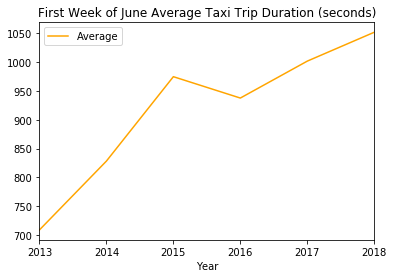

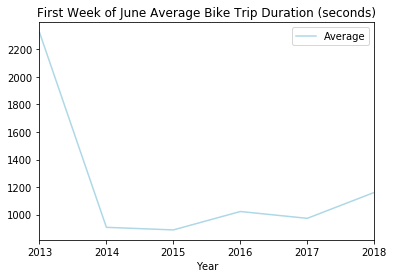

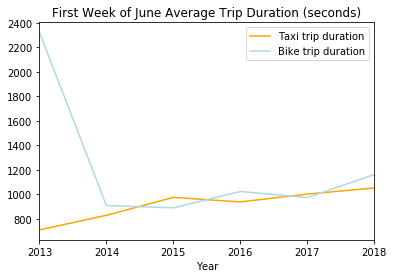

In [103]:
# Create average trip duration dataframes and plot

avg_trip_duration_bike = pd.DataFrame(
    {'Year': YEARS, 
     'Average': [
        df_bike_2013.tripduration.mean(),
        df_bike_2014.tripduration.mean(),
        df_bike_2015.tripduration.mean(),
        df_bike_2016.tripduration.mean(),
        df_bike_2017.tripduration.mean(),
        df_bike_2018.tripduration.mean()] 
    })
print('bike trip duration mean: ',np.mean([
        #df_bike_2013.tripduration.mean(),
        df_bike_2014.tripduration.mean(),
        df_bike_2015.tripduration.mean(),
        df_bike_2016.tripduration.mean(),
        df_bike_2017.tripduration.mean(),
        df_bike_2018.tripduration.mean()] ))

avg_trip_duration_taxi = pd.DataFrame(
    {'Year': YEARS,
     'Average': [
         df_taxi_2013.tripduration.mean(),
         df_taxi_2014.tripduration.mean(),
         df_taxi_2015.tripduration.mean(),
         df_taxi_2016.tripduration.mean(),
         df_taxi_2017.tripduration.mean(),
         df_taxi_2018.tripduration.mean()]
    })

print('taxi trip duration mean:', np.mean([
         #df_taxi_2013.tripduration.mean(),
         df_taxi_2014.tripduration.mean(),
         df_taxi_2015.tripduration.mean(),
         df_taxi_2016.tripduration.mean(),
         df_taxi_2017.tripduration.mean(),
         df_taxi_2018.tripduration.mean()]))

avg_trip_duration_taxi.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Taxi Trip Duration (seconds)', color='orange')

avg_trip_duration_bike.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Bike Trip Duration (seconds)', color='lightblue')

_ = avg_trip_duration_taxi.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Trip Duration (seconds)', color='orange')
avg_trip_duration_bike.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Trip Duration (seconds)', ax=_, color='lightblue')
_.legend(['Taxi trip duration', 'Bike trip duration'])


#fig.savefig('trip_duration.jpg')

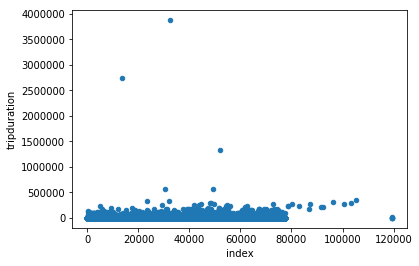

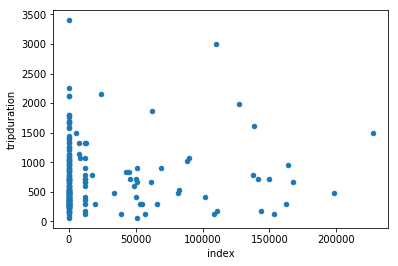

In [55]:
# quick scatter plot--exposes some weird outliers.  
# CitiBike has some >1000 hour trips
# Cabs have some negative time durations

df_bike_2013.reset_index().plot(kind='scatter', x='index', y='tripduration')

df_taxi_2013.reset_index().plot(kind='scatter', x='index', y='tripduration')

### CitiBike rider age

In [56]:
# had to avoid 2014 here, as there are some issues with the birthdate field in that dataframe. Will clean.
# yo people in their 40s love citibikes

citi_avg_age = []

citi_avg_age.append(df_bike_2013["birth year"].mean())
citi_avg_age.append("NaN")
citi_avg_age.append(df_bike_2015["birth year"].mean())
citi_avg_age.append(df_bike_2016["birth year"].mean())
citi_avg_age.append(df_bike_2017["birth year"].mean())
citi_avg_age.append(df_bike_2018["birth year"].mean())

print(citi_avg_age)

[1973.7418080639952, 'NaN', 1976.2964147385587, 1977.4734717561873, 1978.7014382409977, 1978.7112451471332]


### Number of Trips

In [57]:
# Using .loc everywhere here to try to remove the SettingsWithCopyWarning, but still happens unfortunately. No idea how to fix
df_taxi_2013.loc[:,'day'] = df_taxi_2013.loc[:,'pickup_datetime'].map(lambda date: date.strftime('%d (%a)'))
df_taxi_2014.loc[:,'day'] = df_taxi_2014.loc[:,'pickup_datetime'].map(lambda date: date.strftime('%d (%a)'))
df_taxi_2015.loc[:,'day'] = df_taxi_2015.loc[:,'pickup_datetime'].map(lambda date: date.strftime('%d (%a)'))
df_taxi_2016.loc[:,'day'] = df_taxi_2016.loc[:,'pickup_datetime'].map(lambda date: date.strftime('%d (%a)'))
df_taxi_2017.loc[:,'day'] = df_taxi_2017.loc[:,'pickup_datetime'].map(lambda date: date.strftime('%d (%a)'))
df_taxi_2018.loc[:,'day'] = df_taxi_2018.loc[:,'pickup_datetime'].map(lambda date: date.strftime('%d (%a)'))

df_bike_2013.loc[:,'day'] = df_bike_2013.loc[:,'starttime'].map(lambda date: date.strftime('%d (%a)'))
df_bike_2014.loc[:,'day'] = df_bike_2014.loc[:,'starttime'].map(lambda date: date.strftime('%d (%a)'))
df_bike_2015.loc[:,'day'] = df_bike_2015.loc[:,'starttime'].map(lambda date: date.strftime('%d (%a)'))
df_bike_2016.loc[:,'day'] = df_bike_2016.loc[:,'starttime'].map(lambda date: date.strftime('%d (%a)'))
df_bike_2017.loc[:,'day'] = df_bike_2017.loc[:,'starttime'].map(lambda date: date.strftime('%d (%a)'))
df_bike_2018.loc[:,'day'] = df_bike_2018.loc[:,'starttime'].map(lambda date: date.strftime('%d (%a)'))

/home/dan/.local/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/dan/.local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


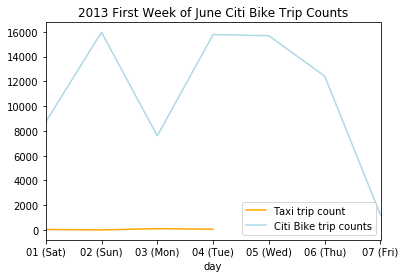

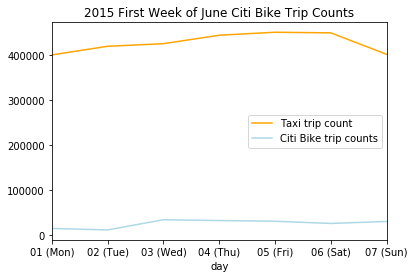

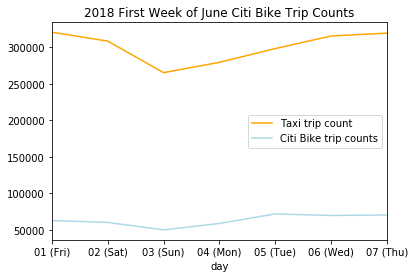

In [58]:
first_plot = df_taxi_2013.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2013 First Week of June Taxi Trip Counts', color='orange')
df_bike_2013.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2013 First Week of June Citi Bike Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip counts'])

first_plot = df_taxi_2015.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2015 First Week of June Taxi Trip Counts', color='orange')
df_bike_2015.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2015 First Week of June Citi Bike Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip counts'])

first_plot = df_taxi_2018.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2018 First Week of June Taxi Trip Counts', color='orange')
df_bike_2018.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2018 First Week of June Citi Bike Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip counts'])

In [59]:
# Make new data frames for yearly trip counts, and graph them

df_taxi_trip_counts = pd.DataFrame({'Year': YEARS, 'Count': [
    df_taxi_2013.groupby(by='day').size().sum(),
    df_taxi_2014.groupby(by='day').size().sum(),
    df_taxi_2015.groupby(by='day').size().sum(),
    df_taxi_2016.groupby(by='day').size().sum(),
    df_taxi_2017.groupby(by='day').size().sum(),
    df_taxi_2018.groupby(by='day').size().sum(),
]})

df_bike_trip_counts = pd.DataFrame({'Year': YEARS, 'Count': [
    df_bike_2013.groupby(by='day').size().sum(),
    df_bike_2014.groupby(by='day').size().sum(),
    df_bike_2015.groupby(by='day').size().sum(),
    df_bike_2016.groupby(by='day').size().sum(),
    df_bike_2017.groupby(by='day').size().sum(),
    df_bike_2018.groupby(by='day').size().sum(),
]})

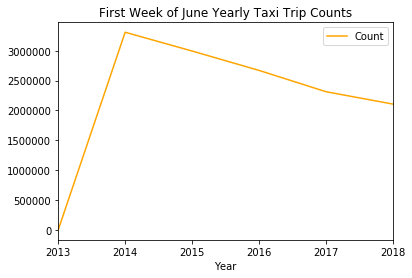

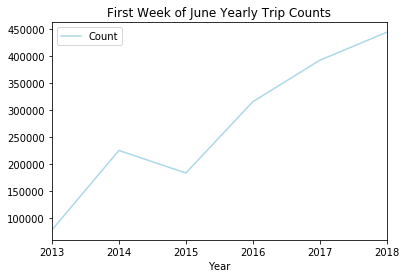

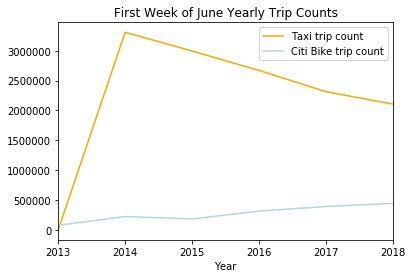

In [60]:
df_taxi_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Taxi Trip Counts', color='orange')
df_bike_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Trip Counts', color='lightblue') 

first_plot = df_taxi_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Taxi Trip Counts', color='orange')
df_bike_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip count'])

#### Popular Routes

In [128]:
print('10 most frequent inter-zone trips by Taxi')
df_taxi_2016[df_taxi_2016.zone_from != df_taxi_2016.zone_to].zone_from_to.value_counts()[0:10]

10 most frequent inter-zone trips by Taxi


Central Park to Midtown Center         40256
Midtown Center to Central Park         38315
Clinton East to Central Park           31024
Central Park to Clinton East           27010
East Chelsea to Clinton East           24702
Lincoln Square East to Central Park    20623
Clinton East to East Chelsea           20514
Central Park to Midtown East           20486
Midtown East to Central Park           20455
Clinton East to Midtown Center         19502
Name: zone_from_to, dtype: int64

In [130]:
print('10 most frequent inter-zone trips by Bike')
df_bike_2016[df_bike_2016.zone_from != df_bike_2016.zone_to].zone_from_to.value_counts()[0:10]

10 most frequent inter-zone trips by Bike


Clinton East to East Chelsea               3050
East Chelsea to Clinton East               2756
Central Park to Clinton East               2104
Greenwich Village North to East Village    1946
East Village to Greenwich Village North    1929
Clinton East to Central Park               1833
Clinton East to Midtown Center             1817
Greenwich Village North to East Chelsea    1814
Central Park to Midtown Center             1811
East Village to Alphabet City              1763
Name: zone_from_to, dtype: int64

In [170]:
print('Most common trips to Manhattanville (City College) Zone by Taxi 2016\n')

zone_from = df_taxi_2016[df_taxi_2016.zone_to == 152.0].zone_from.value_counts().index[0:10]
for zone_id in zone_from:
    z = ZONES_DIC[str(zone_id)]
    print(z.name,'to Manhattanville')

Most common trips to Manhattanville (City College) Zone by Taxi 2016

Central Park to Manhattanville
Bloomingdale to Manhattanville
Clinton East to Manhattanville
Central Harlem North to Manhattanville
Central Harlem to Manhattanville
East Chelsea to Manhattanville
Manhattanville to Manhattanville
Lincoln Square East to Manhattanville
East Harlem North to Manhattanville
Midtown Center to Manhattanville
